## Task

#### Goal
Using the data available in file concrete_data.xls. Apply feature engineering methods to obtain 85% to 95% accuracy  (tolerance limit 95% of the time (confidence level).

#### Resources Available 
The data for this project is available in file https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/

#### 1 - Exploratory data quality report reflecting the following
a. Univariate analysis – data types and description of the independent attributes which should include (name, meaning, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions / tails,  missing values, outliers

b. Bi-variate analysis between the predictor variables and between the predictor variables and target column. Comment on your findings in terms of their relationship and degree of relation if any. Presence of leverage points. Visualize the analysis using boxplots and pair plots, histograms or density curves. Select the most appropriate attributes

c .Strategies to address the different data challenges such as data pollution, outliers and missing values



#### 2 - Feature Engineering techniques

a. Identify opportunities (if any) to create a composite feature, drop a feature

b. Decide on complexity of the model, should it be simple linear mode in terms of parameters or would a quadratic or higher degree help

c .Explore for gaussians. If data is likely to be a mix of gaussians, explore individual clusters and present your findings in terms of the independent attributes and their suitability to predict strength



#### 3 - create the model

a . Obtain feature importance for the individual features using multiple methods and present your findings



#### 4 - Tuning the model

a. Algorithms that you think will be suitable for this project

b. Techniques employed to squeeze that extra performance out of the model without making it overfit or underfit

c. Model performance range at 95% confidence level




Import Libraries:

In [76]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from pdpbox import pdp, get_dataset, info_plots
import statsmodels.api as sm
from scipy import stats
import shap
import random
import category_encoders as ce
from IPython.display import display, Image
import pydot
import os
from apyori import apriori
from random import sample 
import scipy.stats as stats
import scipy
from datetime import datetime
import category_encoders as ce
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import randint as sp_randint
from scipy.stats import zscore
import scipy.cluster.hierarchy as sch

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing 
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Imputer
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import warnings 
warnings.filterwarnings('ignore')

Load and review data:

In [77]:
df = pd.read_csv("concrete (1).csv")
df_backup = df.copy()
print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
df.columns = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg','fineagg', 'age', 'Target']
df.head()

This dataset has 1030 rows, and 9 columns


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,Target
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


I found a function to reduce the memory size without loosing any information:

https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

In [78]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

df, NAlist = reduce_mem_usage(df)

Memory usage of properties dataframe is : 0.0708465576171875  MB
******************************
Column:  cement
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  slag
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  ash
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  water
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  superplastic
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  coarseagg
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  fineagg
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  age
dtype before:  int64
dtype

Checking for nulls and data type:

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float32
slag            1030 non-null float32
ash             1030 non-null float32
water           1030 non-null float32
superplastic    1030 non-null float32
coarseagg       1030 non-null float32
fineagg         1030 non-null float32
age             1030 non-null uint16
Target          1030 non-null float32
dtypes: float32(8), uint16(1)
memory usage: 34.3 KB


Shuffle the dataset because some learning algorithms are sensitive to the order of the training instances. This will also guarantee that all cross-validation folds will be similar.

In [80]:
df = df.sample(frac=1,random_state=1)
df.reset_index(inplace=True,drop=True)

## Unsupervised Learning: K-means Clustering Analysis

I will start by checking if there are any clusters within the data:

In [81]:
cluster_range = range(1,11) 
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters, n_init=5)
  clusters.fit(df.iloc[:,:-1])
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append(clusters.inertia_ )
clusters_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors": cluster_errors})
clusters_df

,num_clusters,cluster_errors
0,1,4.056042e+07
1,2,3.123184e+07
2,3,2.473715e+07
3,4,2.173792e+07
4,5,1.975396e+07
5,6,1.754679e+07
6,7,1.617665e+07
7,8,1.457837e+07
8,9,1.328744e+07
9,10,1.225009e+07


Elbow plot:

Text(0.5, 0, 'Number of Clusters')

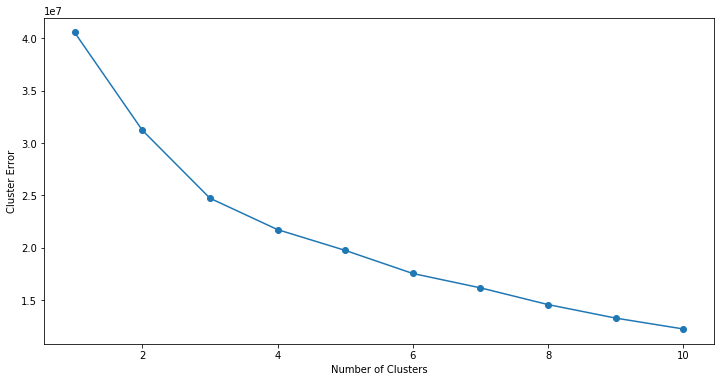

In [82]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.ylabel('Cluster Error')
plt.xlabel('Number of Clusters')

It is very hard to decide if there are 2 or 3 clusters. Let's perform an hierarchical clustering analysis, using the dendrogram to find the optimal number of clusters.

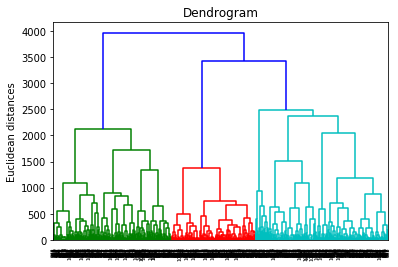

In [8]:
dendrogram = sch.dendrogram(sch.linkage(df.iloc[:,:-1], method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

I can decide the number of optimal clusters by looking at the longest vertical line that doesn't cross any extended horizzontal line. From this we can conclude that are 3 clusters.

Now let's fit the Hierarchical Clustering to the dataset:

In [83]:
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
df['group'] = hc.fit_predict(df.iloc[:,:-1])

## Univariate analysis:

Statistics summary of the dataframe:

In [84]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167755,104.506355,102.000000,192.375000,272.899994,350.000000,540.000000
slag,1030.0,73.895851,86.279182,0.000000,0.000000,22.000000,142.950001,359.399994
ash,1030.0,54.188377,63.997227,0.000000,0.000000,0.000000,118.300003,200.100006
water,1030.0,181.567307,21.354235,121.800003,164.899994,185.000000,192.000000,247.000000
superplastic,1030.0,6.204661,5.973844,0.000000,0.000000,6.400000,10.200000,32.200001
coarseagg,1030.0,972.919006,77.753960,801.000000,932.000000,968.000000,1029.400024,1145.000000
fineagg,1030.0,773.580994,80.175934,594.000000,730.950012,779.500000,824.000000,992.599976
age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
Target,1030.0,35.817955,16.705742,2.330000,23.710001,34.445002,46.135000,82.599998
group,1030.0,0.853398,0.790408,0.000000,0.000000,1.000000,1.000000,2.000000


I might need to take care about the 0s. It looks like they are null values and not actual 0s.

#### Following approach:
I am going to clip all the outliers for the continuous variables and applying tranformations to make the distributions more similar to bell curves (without including the 0s)

Defining the clipping function:

In [85]:
def clip(df,column):
    Q1 = np.percentile(df[df[column]!=0][column],25)
    Q3 = np.percentile(df[df[column]!=0][column],75)
    df[column].clip(Q1-1.5*(Q3-Q1), Q3+1.5*(Q3-Q1), inplace=True)

Adjusting the 'cement':
- No outliers
- Applied transformation because the distribution was slightly skewed to the right

Text(0.5, 1.0, 'Transformed distribution CEMENT')

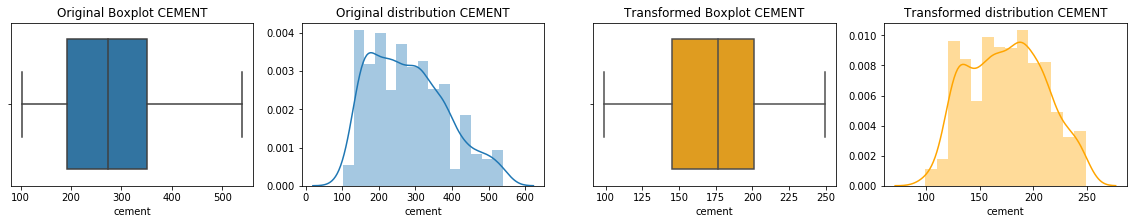

In [86]:
feature, axs = plt.subplots(ncols = 4, figsize=(20, 3))
sns.boxplot(x='cement',data=df, ax=axs[0]).set_title('Original Boxplot CEMENT')
sns.distplot(df['cement'], ax=axs[1]).set_title('Original distribution CEMENT')
df['cement'] = np.log(df['cement'])**3
sns.boxplot(x='cement',data=df, color='orange', ax=axs[2]).set_title('Transformed Boxplot CEMENT')
sns.distplot(df['cement'], color='orange', ax=axs[3]).set_title('Transformed distribution CEMENT')

Adjusting the 'slag':
- Clipped the outliers
- The data without 0s is almost bell distribuited. There is a short tail on the right: no further actions are needed.

Text(0.5, 1.0, 'Transformed distribution SLAG without 0s')

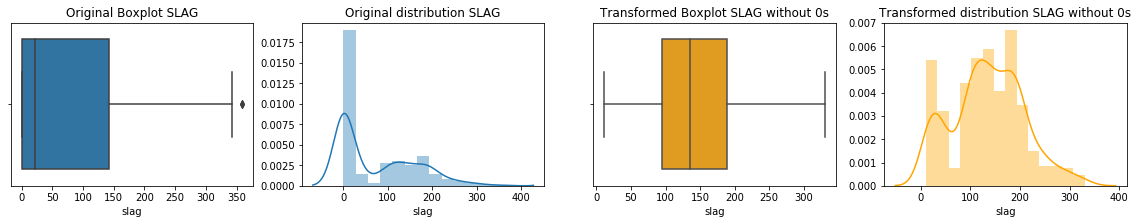

In [87]:
feature, axs = plt.subplots(ncols = 4, figsize=(20, 3))
sns.boxplot(x='slag',data=df, ax=axs[0]).set_title('Original Boxplot SLAG')
sns.distplot(df['slag'], ax=axs[1]).set_title('Original distribution SLAG')
clip(df,'slag')
subset_slag = df[df['slag']!=0]
sns.boxplot(x='slag',data=subset_slag, color='orange', ax=axs[2]).set_title('Transformed Boxplot SLAG without 0s')
sns.distplot(subset_slag['slag'], color='orange', ax=axs[3]).set_title('Transformed distribution SLAG without 0s')

Adjusting the 'water':
- Clipped the outliers in the original distribution
- Applied transformation because the distribution was slightly skewed to the left

Text(0.5, 1.0, 'Transformed distribution WATER')

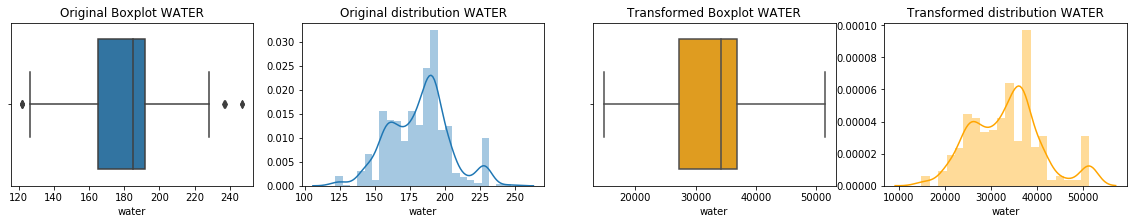

In [88]:
feature, axs = plt.subplots(ncols = 4, figsize=(20, 3))
sns.boxplot(x='water',data=df, ax=axs[0]).set_title('Original Boxplot WATER')
sns.distplot(df['water'], ax=axs[1]).set_title('Original distribution WATER')
df['water'] = (df['water'])**2
clip(df,'water')
sns.boxplot(x='water',data=df, color='orange', ax=axs[2]).set_title('Transformed Boxplot WATER')
sns.distplot(df['water'], color='orange', ax=axs[3]).set_title('Transformed distribution WATER')

Adjusting the 'superplastic':
- Clipped the outliers
- The data without 0s is almost bell distribuited: no further actions are needed.

Text(0.5, 1.0, 'Transformed distribution SUPERPLASTIC without 0s')

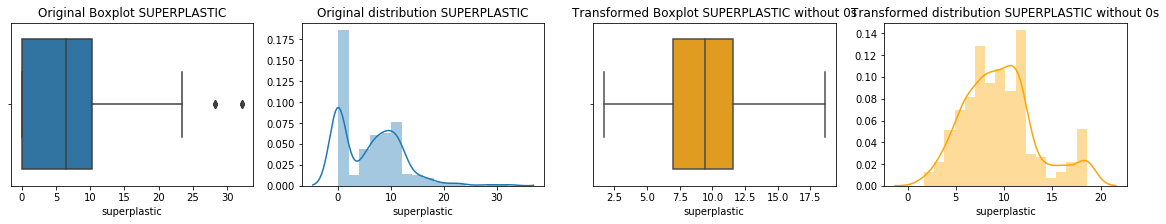

In [89]:
feature, axs = plt.subplots(ncols = 4, figsize=(20, 3))
sns.boxplot(x='superplastic',data=df, ax=axs[0]).set_title('Original Boxplot SUPERPLASTIC')
sns.distplot(df['superplastic'], ax=axs[1]).set_title('Original distribution SUPERPLASTIC')
clip(df,'superplastic')
subset_superplastic = df[df['superplastic']!=0]
sns.boxplot(x='superplastic',data=subset_superplastic, color='orange', ax=axs[2]).set_title('Transformed Boxplot SUPERPLASTIC without 0s')
sns.distplot(subset_superplastic['superplastic'], color='orange', ax=axs[3]).set_title('Transformed distribution SUPERPLASTIC without 0s')

Adjusting the 'fineagg':
- Clipped the outliers

Text(0.5, 1.0, 'Transformed distribution FINEAGG')

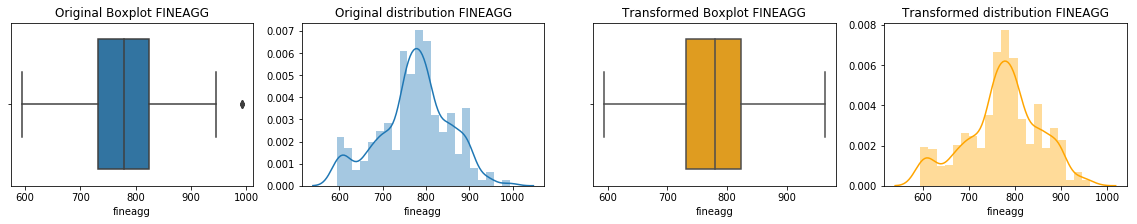

In [90]:
feature, axs = plt.subplots(ncols = 4, figsize=(20, 3))
sns.boxplot(x='fineagg',data=df, ax=axs[0]).set_title('Original Boxplot FINEAGG')
sns.distplot(df['fineagg'], ax=axs[1]).set_title('Original distribution FINEAGG')
clip(df,'fineagg')
sns.boxplot(x='fineagg',data=df, color='orange', ax=axs[2]).set_title('Transformed Boxplot FINEAGG')
sns.distplot(df['fineagg'], color='orange', ax=axs[3]).set_title('Transformed distribution FINEAGG')

Adjusting the 'age':
- Clipped the outliers

Text(0.5, 1.0, 'Transformed distribution AGE')

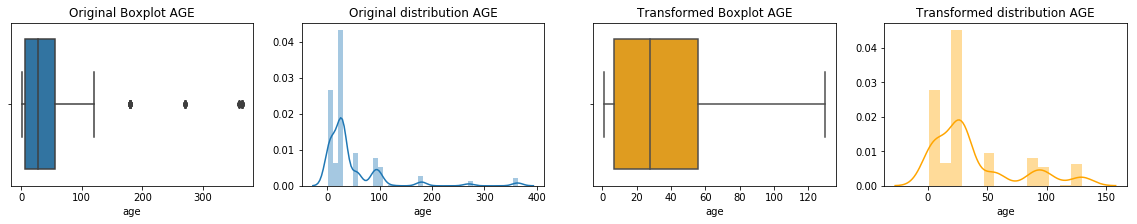

In [91]:
feature, axs = plt.subplots(ncols = 4, figsize=(20, 3))
sns.boxplot(x='age',data=df, ax=axs[0]).set_title('Original Boxplot AGE')
sns.distplot(df['age'], ax=axs[1]).set_title('Original distribution AGE')
clip(df,'age')
sns.boxplot(x='age',data=df, color='orange', ax=axs[2]).set_title('Transformed Boxplot AGE')
sns.distplot(df['age'], color='orange', ax=axs[3]).set_title('Transformed distribution AGE')

## Multivariate analysis:

Identify Correlation in data:

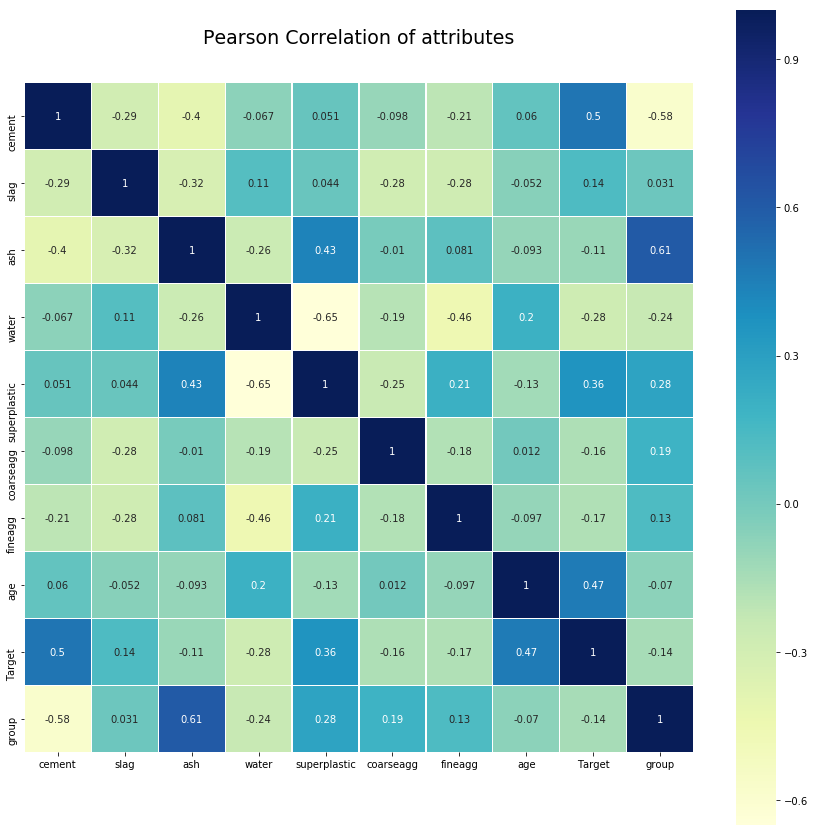

In [18]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of attributes', y=1.05, size=19)
sns.heatmap(df.corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap='YlGnBu', 
            linecolor='white',
            annot=True)

#### Considerations:
- Positive correlation between the 'Target' variable & 'cement' and 'age'.
- There is a strong negative correlation between 'water' and 'superplastic'. The abs correlation is < 0.7 (critical value) and then I am going to keep both the features in the model.

#### Normalize the data: 
The 'Target' and 'group' columns don't need to be normalized.

In [92]:
X = df.iloc[:,:-2]
y = df['Target']
columns = X.columns.to_list()
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = columns
extra_cols = df.iloc[:,-2:]
df = pd.concat([pd.DataFrame(X),pd.DataFrame(extra_cols)],axis=1)
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,Target,group
0,0.427569,0.475758,0.000000,0.602921,0.000000,0.498837,0.419671,0.692607,47.779999,1
1,0.761111,0.000000,0.000000,0.602921,0.000000,0.404070,0.443753,0.692607,48.790001,0
2,0.368881,0.000000,0.870565,0.248132,0.629879,0.730523,0.491105,0.101167,33.700001,2
3,0.195553,0.554545,0.000000,0.613458,0.484522,0.715116,0.278699,0.210117,18.280001,1
4,0.598548,0.000000,0.000000,0.602921,0.000000,0.491279,0.692688,0.046693,14.990000,0


Visual analysis of the clusters usign boxplots:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A795256518>,
      dtype=object)

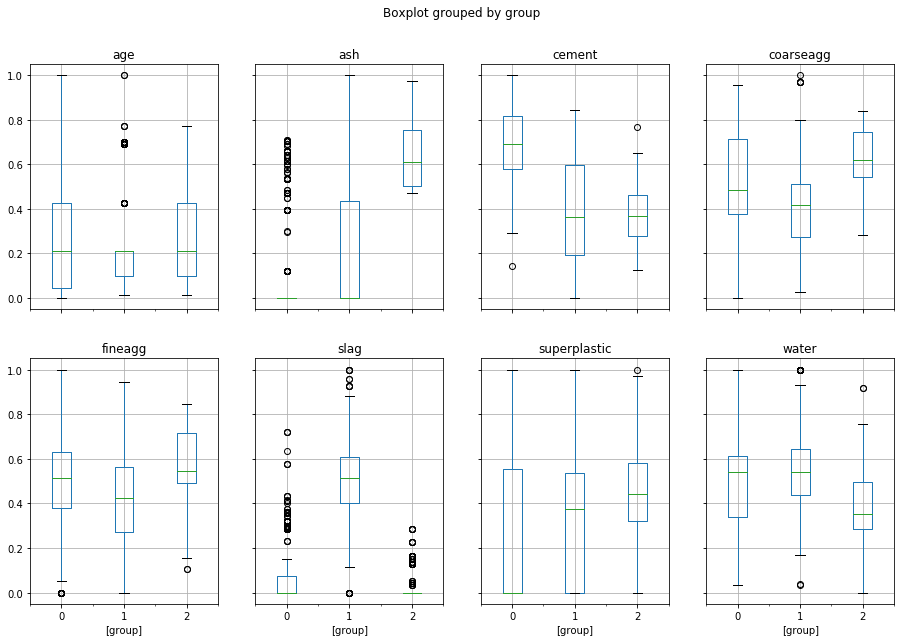

In [20]:
df.drop('Target',axis=1).boxplot(by='group',  layout=(2,4), figsize=(15, 10))

There are few outliers in the view by group. Later I could try to fix and tranform these only on the training set (to avoid to add bias in the test set).

Pairplot: you can zoom the chart by double-clicking on it.

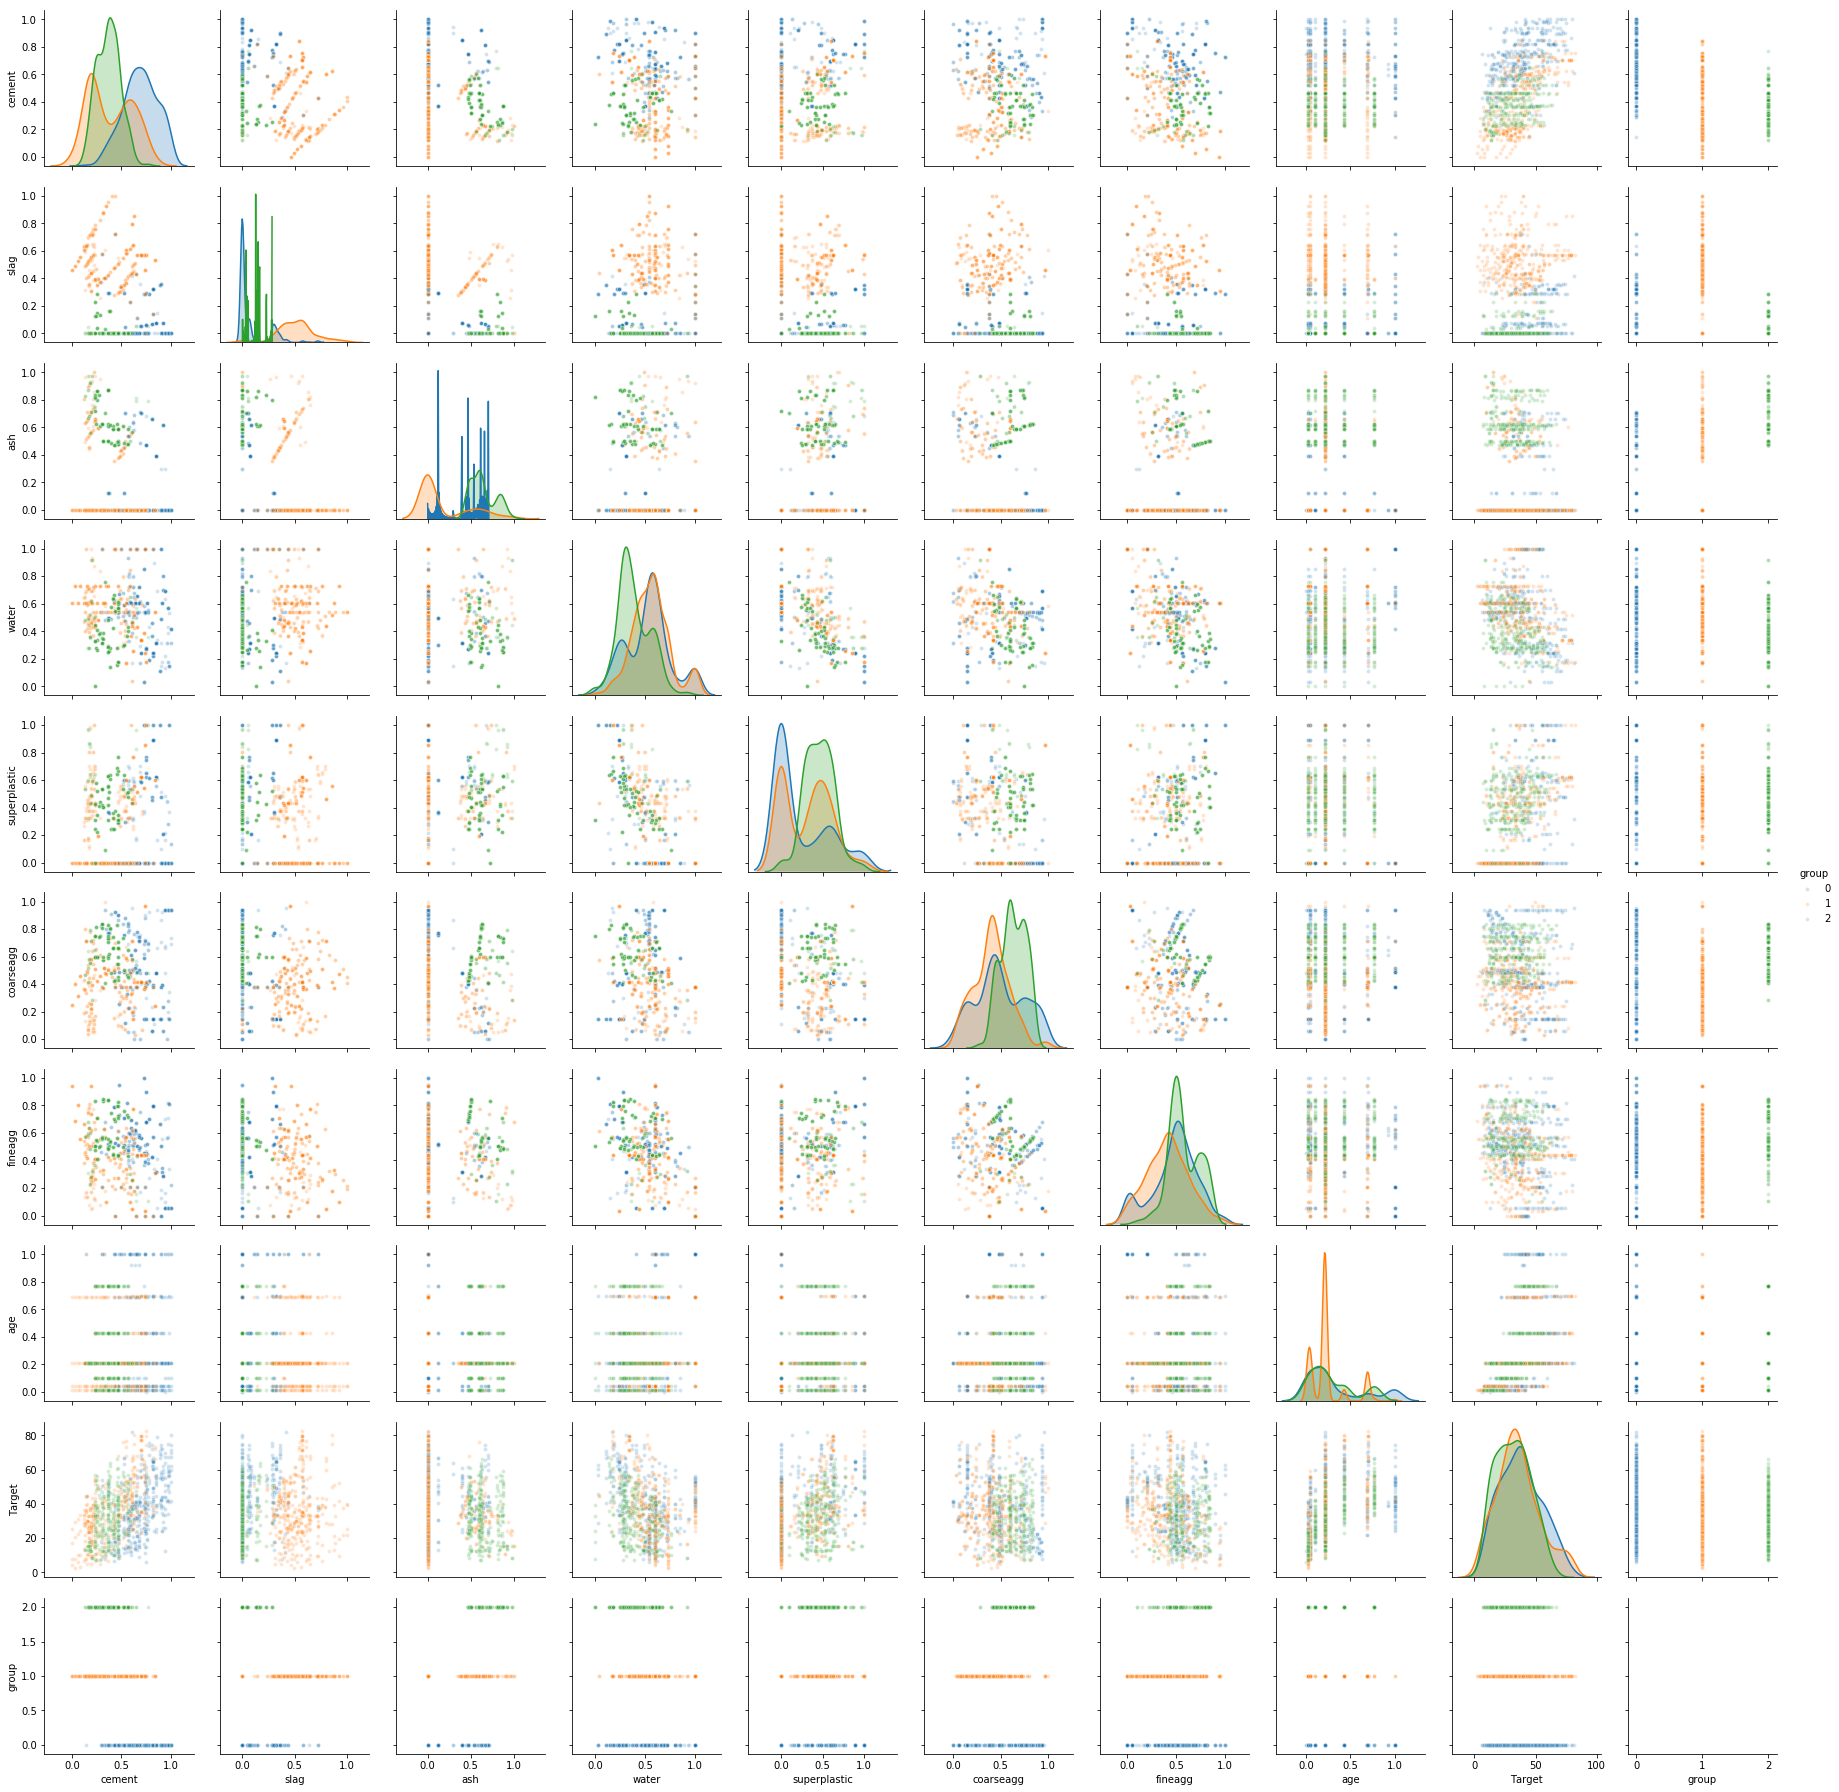

In [21]:
sns.pairplot(df,
             diag_kind='kde',
             hue='group',
             plot_kws={"s": 15,'alpha': 0.2})

## Spliting the data in train and test set
I am going to use 70% of data for training and 30% for testing. I will use grid-search with cross-validation to search for the hyperparameters. Then, I will use the testset to evaluate the models.

In [93]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, test_index in split.split(df, df['group']):
    train = df.loc[train_index]
    test = df.loc[test_index]
    
X_train = train.drop(['Target','group'],axis=1)
X_test = test.drop(['Target','group'],axis=1)
y_train = train['Target']
y_test = test['Target']
    
print('%.0f records (%.0f%%) are used for training \n%.0f records (%.0f%%) are used for testing' % (len(train), (100*len(train)/len(df)), len(test), (100*len(test)/len(df))))

721 records (70%) are used for training 
309 records (30%) are used for testing


Check 'group' ratio of the split data. This is a sanity check to assure a correct stratified sampling of the groups: we would like to have similar ratio in the original dataset, training and test set.

In [94]:
df_ratio = pd.DataFrame(round(df.groupby(['group']).count().Target/len(df),4))
train_ratio = pd.DataFrame(round(train.groupby(['group']).count().Target/len(train),4))
test_ratio = pd.DataFrame(round(test.groupby(['group']).count().Target/len(test),4))
Stratified_split = pd.concat([df_ratio,train_ratio,test_ratio],axis=1)
Stratified_split.columns = ['df','train','test']
Stratified_split

,df,train,test
group,,,
0,0.3961,0.3967,0.3948
1,0.3544,0.3537,0.3560
2,0.2495,0.2497,0.2492


## Randomized search with cross-validation for hyperparameters tuning:

I am going to use MAE as my reference score.

In [95]:
def tuning(model,parameters,iteration=20,n_folds=10,X_train=X_train,y_train=y_train):
    start1=datetime.now()
    randomCV1 = RandomizedSearchCV(model,
                                   param_distributions=parameters,
                                   n_iter=5,
                                   cv=n_folds,
                                   random_state=1)
    randomCV1.fit(X_train, y_train)
    stop1=datetime.now()
    execution_time1 = stop1-start1
    print('Expected execution time is about',iteration*execution_time1/5,'\n')
    
    start=datetime.now()
    randomCV = RandomizedSearchCV(model,
                                  param_distributions=parameters,
                                  n_iter=iteration,
                                  cv=n_folds,
                                  random_state=1)
    randomCV.fit(X_train, y_train)
    stop=datetime.now()
    execution_time = stop-start
    print('Execution time =',execution_time,'\n')
    print('The best combination of hyperparameters is:\n\n',randomCV.best_params_)

#### KNN

In [25]:
param_dist = {'n_neighbors':sp_randint(2, 20)}
tuning(KNeighborsRegressor(),param_dist)

Expected execution time is about 0:00:03.168500 

Execution time = 0:00:02.931255 

The best combination of hyperparameters is:

 {'n_neighbors': 2}


Saving KNN hyperparameters:

In [96]:
knn_hyperparameters = {'n_neighbors': 2}

#### RIDGE

In [28]:
param_dist = {'alpha': np.linspace(0.01,1,100)}
tuning(Ridge(),param_dist)

Expected execution time is about 0:00:01.219332 

Execution time = 0:00:01.301542 

The best combination of hyperparameters is:

 {'alpha': 0.32}


Saving RIDGE hyperparameters:

In [97]:
ridge_hyperparameters = {'alpha': 0.32}

#### LASSO

In [30]:
param_dist = {'alpha': np.linspace(0.01,1,100)}
tuning(Lasso(),param_dist)

Expected execution time is about 0:00:01.086956 

Execution time = 0:00:01.032593 

The best combination of hyperparameters is:

 {'alpha': 0.11}


Saving LASSO hyperparameters:

In [98]:
lasso_hyperparameters = {'alpha': 0.11}

#### ELASTIC NET

In [32]:
param_dist = {'alpha': np.linspace(0.1,10,100),
             'l1_ratio': np.linspace(0,1,11),}
tuning(ElasticNet(),param_dist)

Expected execution time is about 0:00:01.337648 

Execution time = 0:00:01.230339 

The best combination of hyperparameters is:

 {'l1_ratio': 0.5, 'alpha': 0.5}


Saving ELASTICNET hyperparameters:

In [99]:
elasticnet_hyperparameters = {'l1_ratio': 0.5, 
                              'alpha': 0.5}

#### SVM

In [40]:
param_dist = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'C': np.linspace(0.1,10,100),
              'gamma': np.linspace(0.1,10,100)}
tuning(SVR(),param_dist)

Saving SVM hyperparameters:

In [100]:
svm_hyperparameters = {'kernel': 'poly', 
                       'gamma': 4.1, 
                       'C': 0.7000000000000001}

#### DECISION TREE

In [35]:
param_dist = {'max_depth': sp_randint(1, X.shape[1]+1)}
tuning(DecisionTreeRegressor(),param_dist)

Expected execution time is about 0:00:01.358852 

Execution time = 0:00:01.208278 

The best combination of hyperparameters is:

 {'max_depth': 8}


Saving Decision Tree hyperparameters:

In [101]:
dtree_hyperparameters = {'max_depth': 8}

#### BAGGING

In [37]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'max_samples': sp_randint(10, 500),
              'oob_score': [True,False]}
tuning(BaggingRegressor(),param_dist)

Expected execution time is about 0:01:05.408288 

Execution time = 0:01:38.763295 

The best combination of hyperparameters is:

 {'max_samples': 412, 'n_estimators': 478, 'oob_score': False}


Saving Bagging hyperparameters:

In [102]:
bag_hyperparameters = {'max_samples': 412, 
                       'n_estimators': 478, 
                       'oob_score': False}

#### RANDOM FOREST

In [39]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'max_depth': sp_randint(1, X.shape[1]+1),
              'max_features': sp_randint(1, X.shape[1]+1),
              'min_samples_split': sp_randint(2, X.shape[1]+1),
              'min_samples_leaf': sp_randint(1, X.shape[1]+1),
              'bootstrap': [True, False]}
tuning(RandomForestRegressor(),param_dist)

Expected execution time is about 0:01:22.357296 

Execution time = 0:01:29.039675 

The best combination of hyperparameters is:

 {'bootstrap': True, 'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 488}


Saving Random Forest hyperparameters:

In [103]:
rf_hyperparameters = {'bootstrap': True, 
                      'max_depth': 8, 
                      'max_features': 8, 
                      'min_samples_leaf': 2, 
                      'min_samples_split': 3, 
                      'n_estimators': 488}

#### ADABOOST

In [42]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,100)}
tuning(AdaBoostRegressor(),param_dist)

Expected execution time is about 0:01:30.634708 

Execution time = 0:01:43.866967 

The best combination of hyperparameters is:

 {'learning_rate': 0.88, 'n_estimators': 499}


Saving Adaboost hyperparameters:

In [104]:
ada_hyperparameters = {'learning_rate': 0.88, 
                       'n_estimators': 499}

#### XGBOOST

In [44]:
param_dist = {'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30),
              'max_depth': sp_randint(1, X.shape[1]+1),
              'subsample': [0.5,0.8],
              'colsample_bytree': np.linspace(0.2,1,10),
              'gamma': np.linspace(0.1,5,10),
              'booster': ['dart','gblinear'],
              'objective': ['reg:squarederror']
             }
tuning(XGBRegressor(),param_dist)

Expected execution time is about 0:08:02.028568 

Execution time = 0:05:08.741172 

The best combination of hyperparameters is:

 {'booster': 'dart', 'colsample_bytree': 0.6444444444444445, 'gamma': 3.366666666666667, 'learning_rate': 0.07827586206896552, 'max_depth': 5, 'n_estimators': 485, 'objective': 'reg:squarederror', 'subsample': 0.8}


Saving XGBoost hyperparameters:

In [105]:
xgb_hyperparameters = {'booster': 'dart', 
                       'colsample_bytree': 0.6444444444444445, 
                       'gamma': 3.366666666666667, 
                       'learning_rate': 0.07827586206896552, 
                       'max_depth': 5, 
                       'n_estimators': 485, 
                       'objective': 'reg:squarederror', 
                       'subsample': 0.8}

#### LIGHT GBM

In [60]:
param_dist = {'application': ['regression'],
              'feature_fraction': np.linspace(0.3,1,8),
              'erbose_eval': [False,True],
              'booster': ['dart','gbdt'],
              'num_leaves': sp_randint(2, X.shape[1]+1),
              'max_depth': sp_randint(1, X.shape[1]+1),
              'max_bin': sp_randint(10, 200),
              'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30)}
tuning(LGBMRegressor(),param_dist,20)

Expected execution time is about 0:00:11.096236 

Execution time = 0:00:14.147929 

The best combination of hyperparameters is:

 {'application': 'regression', 'booster': 'dart', 'erbose_eval': True, 'feature_fraction': 0.7, 'learning_rate': 0.14655172413793105, 'max_bin': 113, 'max_depth': 8, 'n_estimators': 311, 'num_leaves': 6}


Saving Light GBM hyperparameters:

In [106]:
lgbm_hyperparameters = {'application': 'regression', 
                        'booster': 'dart', 
                        'erbose_eval': True, 
                        'feature_fraction': 0.7, 
                        'learning_rate': 0.14655172413793105, 
                        'max_bin': 113, 
                        'max_depth': 8, 
                        'n_estimators': 311, 
                        'num_leaves': 6}

Below are defined all the models:

In [107]:
knn = KNeighborsRegressor(n_neighbors=knn_hyperparameters.get('n_neighbors'))

ridge = Ridge(alpha=ridge_hyperparameters.get('alpha'),
             random_state=1)

lasso = Lasso(alpha=lasso_hyperparameters.get('alpha'),
             random_state=1)

elasticnet = ElasticNet(alpha=elasticnet_hyperparameters.get('alpha'),
                        l1_ratio=elasticnet_hyperparameters.get('l1_ratio'),
                        random_state=1)

svm = SVR(kernel=svm_hyperparameters.get('kernel'),
          C=svm_hyperparameters.get('C'),
          gamma=svm_hyperparameters.get('gamma'))

dtree = DecisionTreeRegressor(max_depth=dtree_hyperparameters.get('max_depth'),
                              random_state=1)

bag = BaggingRegressor(n_estimators=bag_hyperparameters.get('n_estimators'),
                       max_samples=bag_hyperparameters.get('max_samples'),
                       oob_score=bag_hyperparameters.get('oob_score'),
                       random_state=1)

rf = RandomForestRegressor(n_estimators=rf_hyperparameters.get('n_estimators'),
                           max_depth=rf_hyperparameters.get('max_depth'),
                           max_features=rf_hyperparameters.get('max_features'),
                           min_samples_split=rf_hyperparameters.get('min_samples_split'),
                           min_samples_leaf=rf_hyperparameters.get('min_samples_leaf'),
                           bootstrap=rf_hyperparameters.get('bootstrap'),
                           random_state=1)

ada = AdaBoostRegressor(n_estimators=ada_hyperparameters.get('n_estimators'),
                        learning_rate=ada_hyperparameters.get('learning_rate'),
                        random_state=1)

xgb = xgboost.XGBRegressor(n_estimators=xgb_hyperparameters.get('n_estimators'),
                   learning_rate=xgb_hyperparameters.get('learning_rate'),
                   max_depth=xgb_hyperparameters.get('max_depth'),
                   subsample=xgb_hyperparameters.get('subsample'),
                   colsample_bytree=xgb_hyperparameters.get('colsample_bytree'),
                   gamma=xgb_hyperparameters.get('gamma'),
                   booster=xgb_hyperparameters.get('booster'),
                   objective= xgb_hyperparameters.get('objective'),
                   random_state=1)

lgbm = LGBMRegressor(application=lgbm_hyperparameters.get('application'),
                     objective=lgbm_hyperparameters.get('objective'),
                     is_unbalance=lgbm_hyperparameters.get('is_unbalance'),
                     feature_fraction=lgbm_hyperparameters.get('feature_fraction'),
                     bagging_fraction=lgbm_hyperparameters.get('bagging_fraction'),
                     bagging_freq=lgbm_hyperparameters.get('bagging_freq'),
                     verbose=lgbm_hyperparameters.get('verbose'),
                     booster=lgbm_hyperparameters.get('booster'),                  
                     erbose_eval=lgbm_hyperparameters.get('erbose_eval'),
                     num_leaves=lgbm_hyperparameters.get('num_leaves'),
                     max_depth=lgbm_hyperparameters.get('max_depth'),
                     max_bin=lgbm_hyperparameters.get('max_bin'),                      
                     n_estimators=lgbm_hyperparameters.get('n_estimators'),     
                     learning_rate=lgbm_hyperparameters.get('learning_rate'), 
                     random_state=1)

Redefining the list of all the models I need to evaluate:

In [108]:
models_list = [{'label': 'KNN','model': knn,}, 
               {'label': 'Ridge','model': ridge,},   
               {'label': 'Lasso','model': lasso,},   
               {'label': 'ElasticNet','model': elasticnet,},   
               {'label': 'SVM','model': svm,},
               {'label': 'Decision Tree','model': dtree,},
               {'label': 'Bagging','model': bag,},               
               {'label': 'Random Forest','model': rf,},
               {'label': 'Adaboost','model': ada,},
               {'label': 'XGBoost','model': xgb,}, 
               {'label': 'Light GBM','model': lgbm,},]

Defining a function to evaluate the models:

In [109]:
def models_evaluation(models,X_train=X_train, X_test=X_test, plot=True):
    """
    Return the join plot for the distribution of Actual vs Predicted values and
    the MAE for every model contained in the 'models' list
    """
    Models = []
    MAEs = []
    MEAs_train = []
    for i in range(0,len(models)):
        model = models[i].get('model')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        MAE = round(metrics.mean_absolute_error(y_test, y_pred),3)
        MAE_train = round(metrics.mean_absolute_error(y_train, y_pred_train),3)
        Models.append(models[i].get('label'))
        MAEs.append(MAE)
        MEAs_train.append(MAE_train)
        if plot==True:
            sns.jointplot(height=5, x=y_test.values.reshape(len(y_test),), y=pd.DataFrame(y_pred).values.reshape(len(y_pred),), kind="reg").annotate(stats.pearsonr)
            plt.ylabel('Predicted')
            plt.xlabel('True')
            print('\n\n     ',models[i].get('label'))
            plt.show()
    report = pd.concat([pd.DataFrame(Models),pd.DataFrame(MAEs),pd.DataFrame(MEAs_train)],axis=1)
    report.columns = ['Model','MAE','MEA training']
    report = report.sort_values('MAE')
    report.set_index('Model',inplace=True,drop=True)
    return(report)

Evaluation of all the models contained in 'models_list':



      KNN


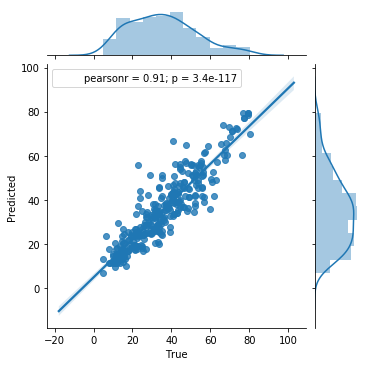



      Ridge


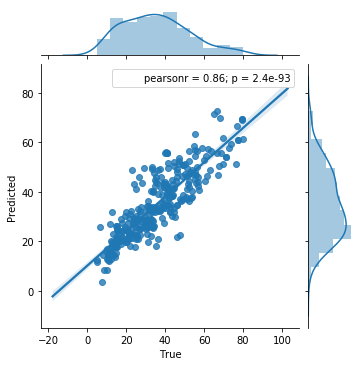



      Lasso


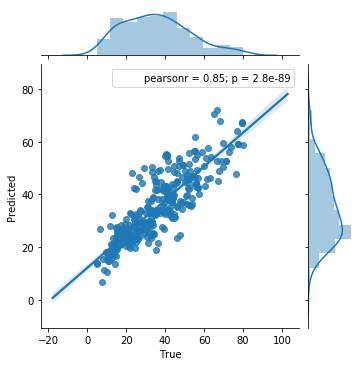



      ElasticNet


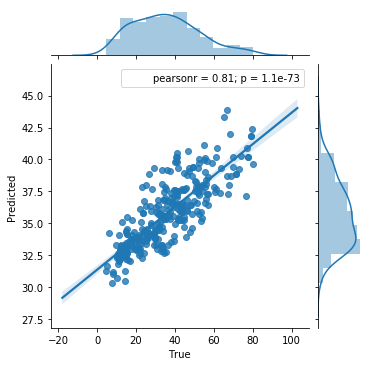



      SVM


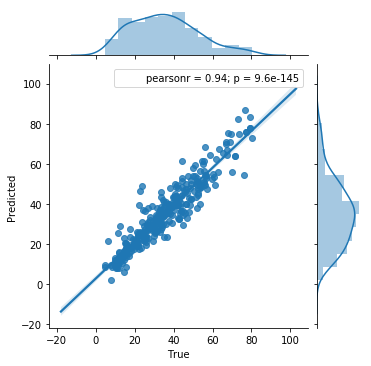



      Decision Tree


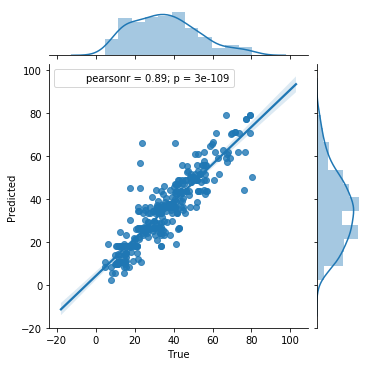



      Bagging


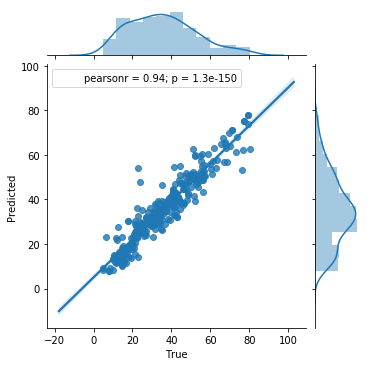



      Random Forest


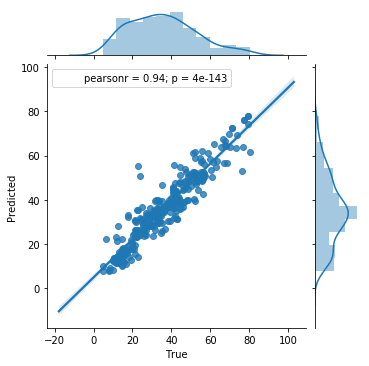



      Adaboost


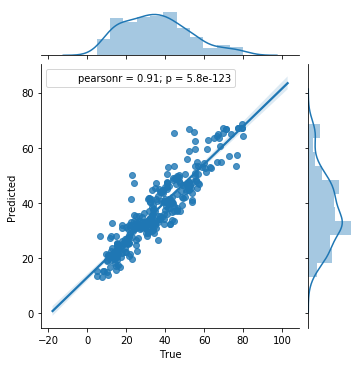



      XGBoost


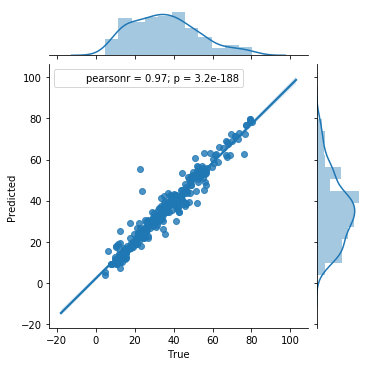



      Light GBM


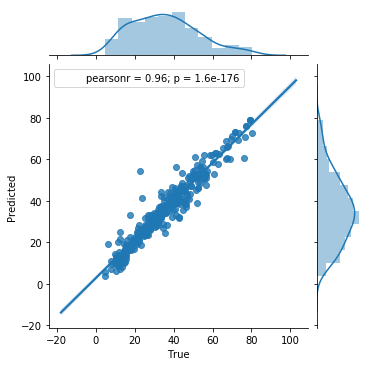

,MAE,MEA training
Model,,
XGBoost,2.699,0.808
Light GBM,3.111,1.792
Bagging,3.895,2.189
Random Forest,4.104,2.424
SVM,4.212,3.438
KNN,5.166,3.013
Decision Tree,5.233,2.390
Adaboost,6.292,5.959
Ridge,6.737,6.636


In [110]:
models_evaluation(models_list)

XGBoost and Light GBM have very similar performances on the test set, but light GBM is 20 times faster. I could also plot one tree of the ensemble:

Plotting 1st tree...


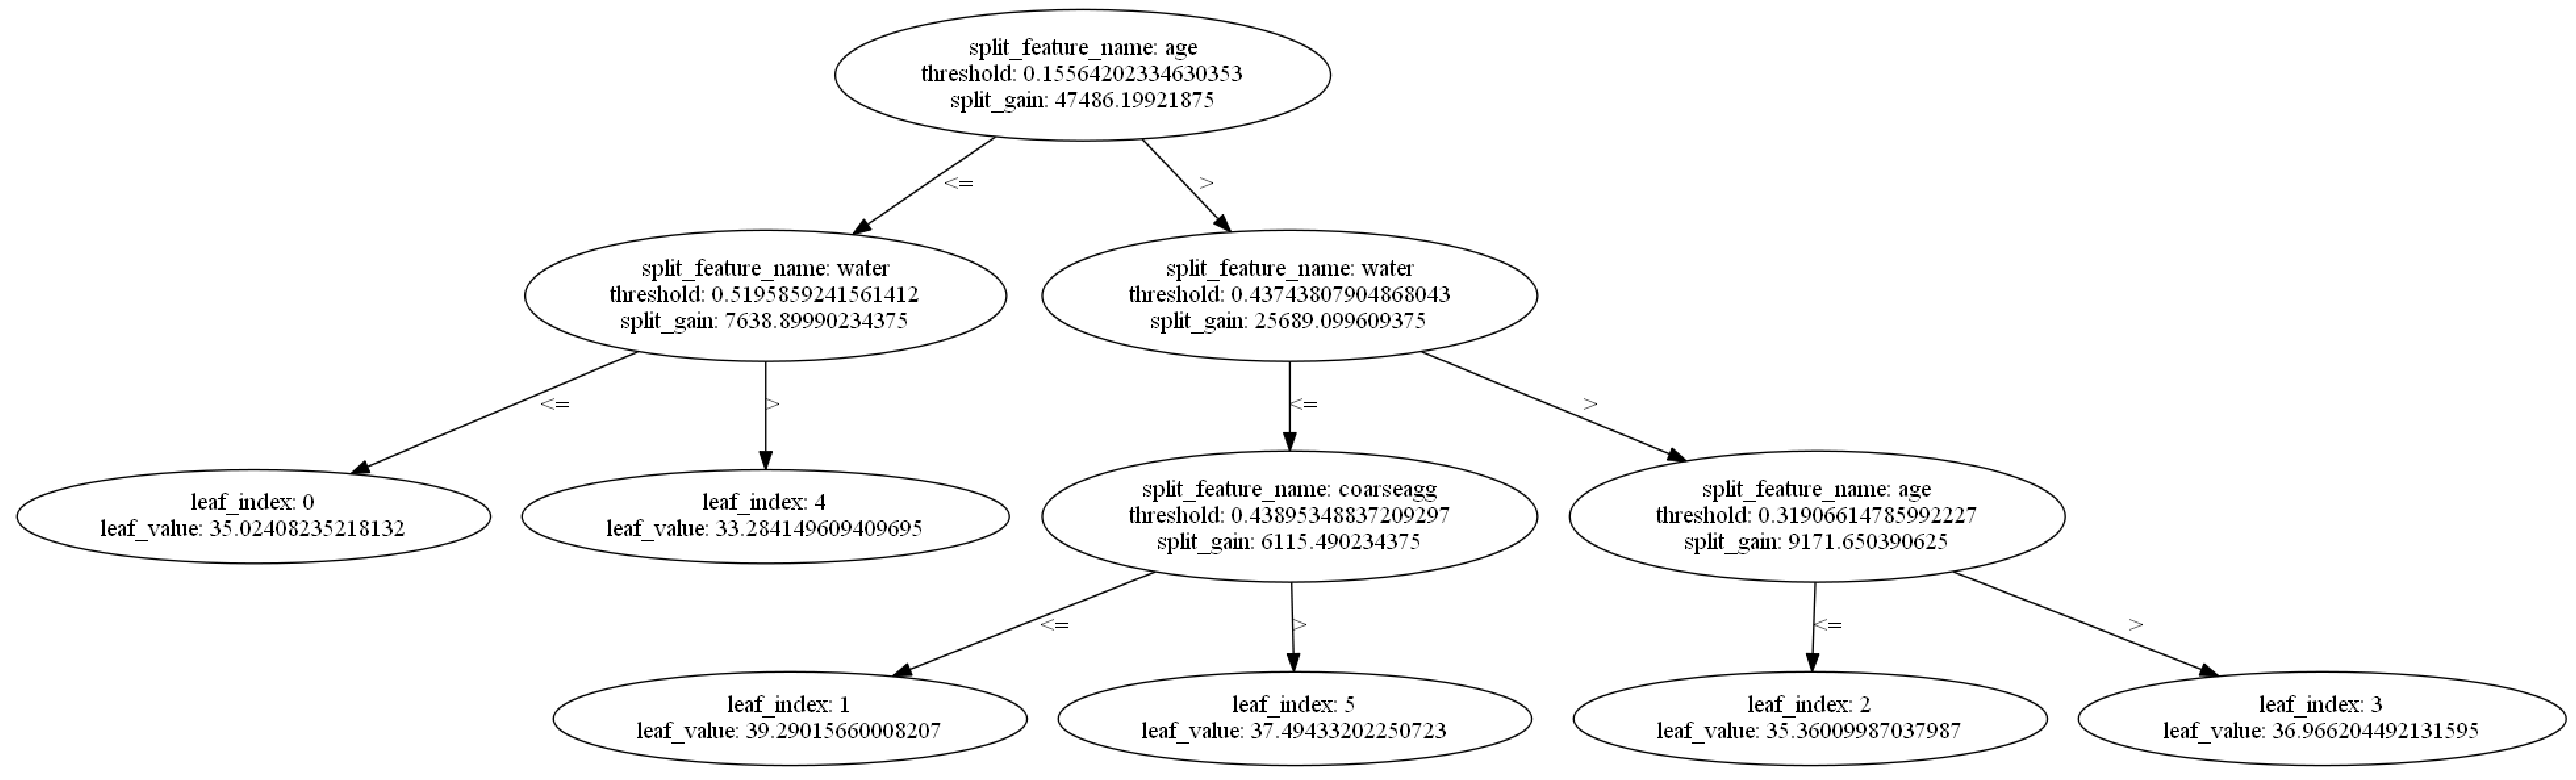

In [41]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
print('Plotting 1st tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(lgbm, tree_index=0, figsize=(15, 15), show_info=['split_gain'])
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

The execution time might be slow. If it is, run the following code to visualize the first tree:

In [42]:
print('Plotting 1st tree with graphviz...')
graph = lgb.create_tree_digraph(lgbm, tree_index=0, name='Tree1')
graph.render(view=True)

Plotting 1st tree with graphviz...


'Tree1.gv.pdf'

Undestand what fuatures are important: I could use the Light GBM regressor with the 'feature_importances_' method.

Text(0, 0.5, 'Features')

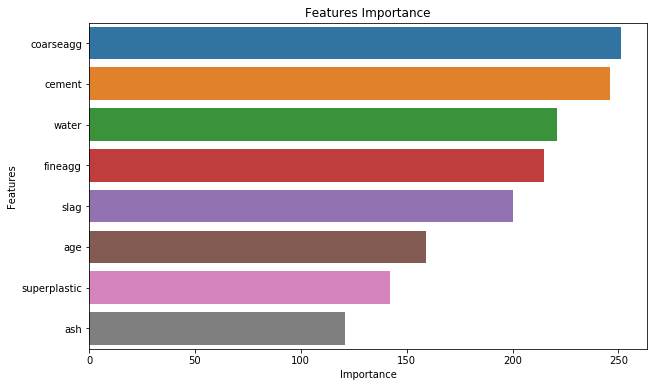

In [111]:
lgbm.fit(X,y)
plt.figure(figsize=(10,6))
plt.title("Features Importance")
features_importance = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(lgbm.feature_importances_)], axis=1)
features_importance.columns = ['Feature','Importance']
features_importance = features_importance.sort_values('Importance',ascending=False)
sns.barplot(x=features_importance.iloc[:,1], y=features_importance.iloc[:,0])
plt.xlabel("Importance")
plt.ylabel("Features")

Let's generate polynomial models reflecting the non-linear interaction between some dimensions:

In [112]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_copy = X
Xpoly = poly.fit_transform(X)
Xpoly_names = []
for i in range(0,Xpoly.shape[1]):
    Xpoly_names.append('feature '+str(i))
Xpoly = pd.DataFrame(Xpoly)
Xpoly.columns = Xpoly_names
dfpoly = pd.concat([Xpoly,df.iloc[:,-2:]],axis=1)
dfpoly.head()

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,...,feature 29,feature 30,feature 31,feature 32,feature 33,feature 34,feature 35,feature 36,Target,group
0,1.0,0.427569,0.475758,0.000000,0.602921,0.000000,0.498837,0.419671,0.692607,0.203419,...,0.253028,0.417587,0.000000,0.000000,0.000000,0.209348,0.345498,0.290667,47.779999,1
1,1.0,0.761111,0.000000,0.000000,0.602921,0.000000,0.404070,0.443753,0.692607,0.000000,...,0.267548,0.417587,0.000000,0.000000,0.000000,0.179307,0.279862,0.307346,48.790001,0
2,1.0,0.368881,0.000000,0.870565,0.248132,0.629879,0.730523,0.491105,0.101167,0.000000,...,0.121859,0.025103,0.460141,0.309336,0.063723,0.358763,0.073905,0.049684,33.700001,2
3,1.0,0.195553,0.554545,0.000000,0.613458,0.484522,0.715116,0.278699,0.210117,0.108443,...,0.170970,0.128898,0.346490,0.135036,0.101806,0.199302,0.150258,0.058559,18.280001,1
4,1.0,0.598548,0.000000,0.000000,0.602921,0.000000,0.491279,0.692688,0.046693,0.000000,...,0.417636,0.028152,0.000000,0.000000,0.000000,0.340303,0.022939,0.032343,14.990000,0


Splitting the data in training and test set:

In [113]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for trainpoly_index, testpoly_index in split.split(dfpoly, dfpoly['group']):
    trainpoly = dfpoly.loc[trainpoly_index]
    testpoly = dfpoly.loc[testpoly_index]
    
Xpoly_train = trainpoly.drop(['Target','group'],axis=1)
Xpoly_test = testpoly.drop(['Target','group'],axis=1)
ypoly_train = trainpoly['Target']
ypoly_test = testpoly['Target']
Xpoly = dfpoly.drop(['Target','group'],axis=1)
ypoly = dfpoly['Target']
    
print('%.0f records (%.0f%%) are used for training \n%.0f records (%.0f%%) are used for testing' % (len(trainpoly), (100*len(trainpoly)/len(dfpoly)), len(testpoly), (100*len(testpoly)/len(dfpoly))))

721 records (70%) are used for training 
309 records (30%) are used for testing


Tuning the poly dataset using Light GBM:

In [69]:
param_dist = {'application': ['regression'],
              'feature_fraction': np.linspace(0.3,1,8),
              'erbose_eval': [False,True],
              'booster': ['dart','gbdt'],
              'num_leaves': sp_randint(2, Xpoly.shape[0]),
              'max_depth': sp_randint(1, Xpoly.shape[1]),
              'max_bin': sp_randint(10, 200),
              'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30)}

tuning(LGBMRegressor(),param_dist,X_train=Xpoly_train,y_train=ypoly_train)

Expected execution time is about 0:01:32.235924 

Execution time = 0:01:36.765132 

The best combination of hyperparameters is:

 {'application': 'regression', 'booster': 'gbdt', 'erbose_eval': False, 'feature_fraction': 0.39999999999999997, 'learning_rate': 0.04413793103448276, 'max_bin': 138, 'max_depth': 18, 'n_estimators': 274, 'num_leaves': 730}


Saving Light GBM hyperparameters poly:

In [114]:
lgbm_hyperparameters_poly = {'application': 'regression', 
                             'booster': 'gbdt', 
                             'erbose_eval': False, 
                             'feature_fraction': 0.39999999999999997, 
                             'learning_rate': 0.04413793103448276, 
                             'max_bin': 138, 
                             'max_depth': 18, 
                             'n_estimators': 274, 
                             'num_leaves': 730}

Evaluation of the Light GBM using the new X poly:

In [115]:
lgbm_poly = LGBMRegressor(application=lgbm_hyperparameters_poly.get('application'),
                          objective=lgbm_hyperparameters_poly.get('objective'),
                          is_unbalance=lgbm_hyperparameters_poly.get('is_unbalance'),
                          feature_fraction=lgbm_hyperparameters_poly.get('feature_fraction'),
                          bagging_fraction=lgbm_hyperparameters_poly.get('bagging_fraction'),
                          bagging_freq=lgbm_hyperparameters_poly.get('bagging_freq'),
                          verbose=lgbm_hyperparameters_poly.get('verbose'),
                          booster=lgbm_hyperparameters_poly.get('booster'),                  
                          erbose_eval=lgbm_hyperparameters_poly.get('erbose_eval'),
                          num_leaves=lgbm_hyperparameters_poly.get('num_leaves'),
                          max_depth=lgbm_hyperparameters_poly.get('max_depth'),
                          max_bin=lgbm_hyperparameters_poly.get('max_bin'),                      
                          n_estimators=lgbm_hyperparameters_poly.get('n_estimators'),     
                          learning_rate=lgbm_hyperparameters_poly.get('learning_rate'), 
                          random_state=1)

models_evaluation([{'label': 'Light GBM','model': lgbm_poly,},],Xpoly_train, Xpoly_test, plot=False)

,MAE,MEA training
Model,,
Light GBM,2.746,0.928


The performance slightly improved. Let's try to plot the importance of the new features:

Text(0, 0.5, 'Features')

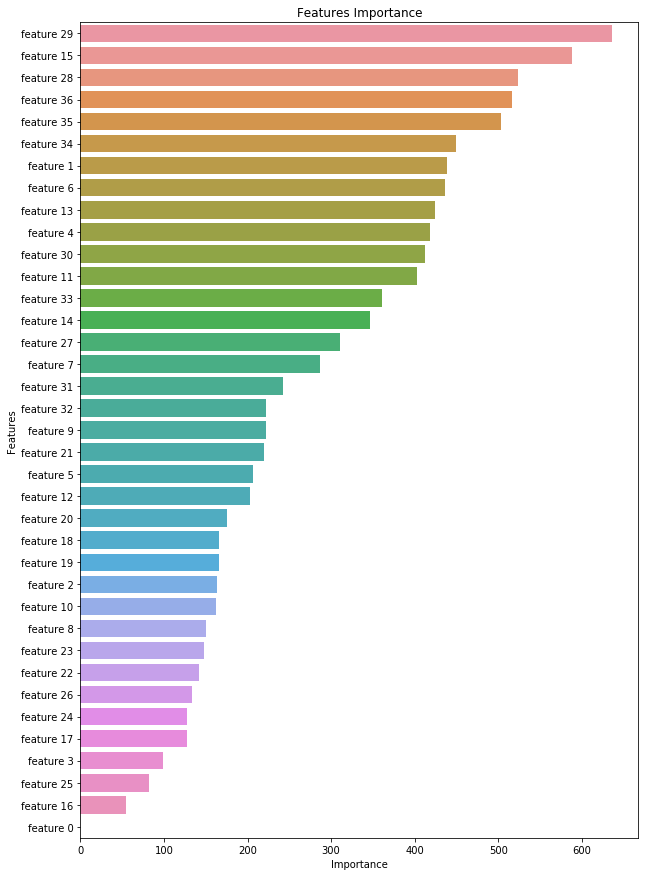

In [116]:
lgbm_poly.fit(Xpoly,ypoly)
plt.figure(figsize=(10,15))
plt.title("Features Importance")
features_importance = pd.concat([pd.DataFrame(Xpoly.columns),pd.DataFrame(lgbm_poly.feature_importances_)], axis=1)
features_importance.columns = ['Feature','Importance']
features_importance = features_importance.sort_values('Importance',ascending=False)
sns.barplot(x=features_importance.iloc[:,1], y=features_importance.iloc[:,0])
plt.xlabel("Importance")
plt.ylabel("Features")

I denfinitely created few features that seem to be extremelly useful. I could try to reduce the size of the dataset using PCA.

## PCA: Principal Component Analysis

The optimal number of Principal Components is 11


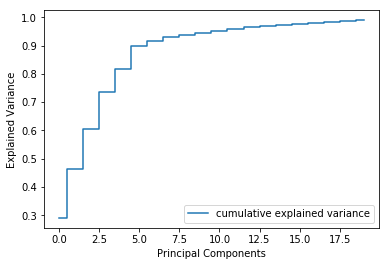

In [117]:
pca = PCA()
pca.fit(Xpoly)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
cum_var_exp = cum_var_exp[cum_var_exp<0.99]
plt.step(range(0, cum_var_exp.shape[0]),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
print('The optimal number of Principal Components is %d' % d)
plt.show()

Applying PCA indipendently on Xpoly_train and Xpoly_test to avoid overfitting:

In [118]:
pca = PCA(n_components = d)
Xpca_train = pca.fit_transform(Xpoly_train)
Xpca_test = pca.transform(Xpoly_test)

Tuning the PCA dataset using Light GBM:

In [119]:
param_dist = {'application': ['regression'],
              'feature_fraction': np.linspace(0.3,1,8),
              'erbose_eval': [False,True],
              'booster': ['dart','gbdt'],
              'num_leaves': sp_randint(2, Xpca_train.shape[0]),
              'max_depth': sp_randint(1, Xpca_train.shape[1]),
              'max_bin': sp_randint(10, 200),
              'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30)}

tuning(LGBMRegressor(),param_dist,X_train=Xpca_train,y_train=ypoly_train)

Expected execution time is about 0:00:29.001020 

Execution time = 0:00:38.851948 

The best combination of hyperparameters is:

 {'application': 'regression', 'booster': 'gbdt', 'erbose_eval': False, 'feature_fraction': 0.8999999999999999, 'learning_rate': 0.31724137931034485, 'max_bin': 136, 'max_depth': 8, 'n_estimators': 391, 'num_leaves': 358}


Saving Light GBM hyperparameters for PCA:

In [120]:
lgbm_hyperparameters_pca = {'application': 'regression', 
                            'booster': 'gbdt', 'erbose_eval': False, 
                            'feature_fraction': 0.8999999999999999, 
                            'learning_rate': 0.31724137931034485, 
                            'max_bin': 136, 
                            'max_depth': 8, 
                            'n_estimators': 391, 
                            'num_leaves': 358}

Evaluation of the Light GBM using the PCA on X poly:

In [121]:
lgbm_pca = LGBMRegressor(application=lgbm_hyperparameters_pca.get('application'),
                         objective=lgbm_hyperparameters_pca.get('objective'),
                         is_unbalance=lgbm_hyperparameters_pca.get('is_unbalance'),
                         feature_fraction=lgbm_hyperparameters_pca.get('feature_fraction'),
                         bagging_fraction=lgbm_hyperparameters_pca.get('bagging_fraction'),
                         bagging_freq=lgbm_hyperparameters_pca.get('bagging_freq'),
                         verbose=lgbm_hyperparameters_pca.get('verbose'),
                         booster=lgbm_hyperparameters_pca.get('booster'),                  
                         erbose_eval=lgbm_hyperparameters_pca.get('erbose_eval'),
                         num_leaves=lgbm_hyperparameters_pca.get('num_leaves'),
                         max_depth=lgbm_hyperparameters_pca.get('max_depth'),
                         max_bin=lgbm_hyperparameters_pca.get('max_bin'),                      
                         n_estimators=lgbm_hyperparameters_pca.get('n_estimators'),     
                         learning_rate=lgbm_hyperparameters_pca.get('learning_rate'), 
                         random_state=1)

models_evaluation([{'label': 'Light GBM','model': lgbm_pca,},],Xpca_train, Xpca_test, plot=False)

,MAE,MEA training
Model,,
Light GBM,4.095,0.117


PCA didn't help at all. We also overfitted. Since none of the techniques seems to help, I'd keep the poly Light GBM for production.

Model performance range at 95% confidence level:

I am 95% confident that the MAE of the model in production will be between 2.6 and 3.3


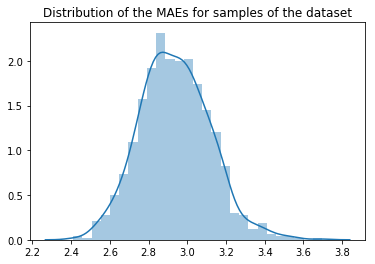

In [126]:
MAEs = []
for i in range(1,1000):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=i)
    for trainpoly_index, testpoly_index in split.split(dfpoly, dfpoly['group']):
        trainpoly = dfpoly.loc[trainpoly_index]
        testpoly = dfpoly.loc[testpoly_index]
    Xpoly_train = trainpoly.drop(['Target','group'],axis=1)
    Xpoly_test = testpoly.drop(['Target','group'],axis=1)
    ypoly_train = trainpoly['Target']
    ypoly_test = testpoly['Target']
    lgbm_poly.fit(Xpoly_train, ypoly_train)
    y_pred = lgbm_poly.predict(Xpoly_test)
    MAE = metrics.mean_absolute_error(ypoly_test, y_pred)
    MAEs.append(MAE)
    
sns.distplot(MAEs, kde=True).set_title('Distribution of the MAEs for samples of the dataset')
alpha = 0.95                             
p = 100*((1.0-alpha)/2.0)             
lower = max(0.0, np.percentile(MAEs, p))  
upper = max(0.0, np.percentile(MAEs, 100-p))
print('I am %.0f%% confident that the MAE of the model in production will be between %.1f and %.1f' % (alpha*100, lower, upper))